## Create data

### Create the train dataset

In [64]:
import deeptrack as dt 
from numpy.random import uniform
import numpy as np

image_size = 51

particle1 = dt.PointParticle(
    position=lambda: uniform(image_size / 2 - 20, image_size / 2 + 20, size=2),
)

particle2 = dt.Ellipse(
            intensity=0.08,
            position_unit="pixel",
            position=lambda: uniform(image_size / 2 - 20, image_size / 2 + 20, size=2),
            radius=(1e-6, 0.2e-6),
            rotation=lambda: np.random.uniform(0, 2 * np.pi),
        )

optics = dt.Fluorescence(output_region=(0, 0, image_size, image_size))

import torch

simulation1 = (
    optics(particle1) 
    >> dt.NormalizeMinMax(0, 1)
    >> dt.Gaussian(sigma=0.1)
    >> dt.MoveAxis(-1, 0)
    >> dt.pytorch.ToTensor(dtype=torch.float32)
)

simulation2 = (
    optics(particle2) 
    >> dt.NormalizeMinMax(0, 1)
    >> dt.Gaussian(sigma=0.1)
    >> dt.MoveAxis(-1, 0)
    >> dt.pytorch.ToTensor(dtype=torch.float32)
)

train_dataset1 = dt.pytorch.Dataset(simulation1 & [0], length=50)
train_dataset2 = dt.pytorch.Dataset(simulation2 & [1], length=50)

Combine them:

In [67]:
from torch.utils.data import ConcatDataset

train_dataset = ConcatDataset([train_dataset1, train_dataset2])
# train_dataset = train_dataset1


print(train_dataset[0])
print(train_dataset[50])

(tensor([[[-0.0683,  0.0786, -0.0130,  ...,  0.0574, -0.3296, -0.0919],
         [-0.0979, -0.0028, -0.0411,  ...,  0.0045, -0.0679,  0.1444],
         [-0.0147,  0.0571, -0.0691,  ..., -0.0179,  0.0198, -0.0188],
         ...,
         [ 0.1016, -0.0851,  0.1878,  ...,  0.0731, -0.0109,  0.1102],
         [ 0.0604,  0.1450, -0.0227,  ...,  0.0436,  0.1392, -0.0704],
         [ 0.0646,  0.1298, -0.0118,  ..., -0.1406, -0.0354,  0.0644]]]), tensor([0]))
(tensor([[[ 0.0427,  0.0647,  0.0849,  ..., -0.1150, -0.0268,  0.1139],
         [-0.0229,  0.0853,  0.0064,  ..., -0.1289,  0.0420,  0.0294],
         [-0.1544,  0.0068, -0.0632,  ...,  0.1714,  0.0564, -0.0541],
         ...,
         [ 0.1036,  0.1069, -0.0352,  ..., -0.0622, -0.0319, -0.0161],
         [ 0.0168, -0.1097, -0.1459,  ..., -0.1110,  0.0660, -0.1461],
         [ 0.0474,  0.0742, -0.1049,  ...,  0.0764, -0.1303,  0.1000]]]), tensor([1]))


### Create test dataset

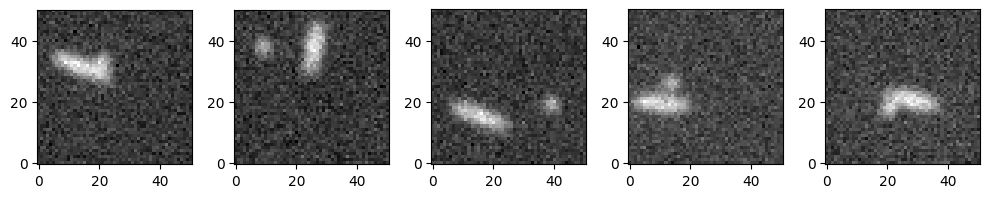

In [68]:
simulation = (
    optics(particle2 >> particle1)
    >> dt.NormalizeMinMax(0, 1)
    >> dt.Gaussian(sigma=0.1)
    >> dt.MoveAxis(-1, 0)
    >> dt.pytorch.ToTensor(dtype=torch.float32)
)

test_dataset = dt.pytorch.Dataset(simulation & particle1.position & particle2.position, length=100)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 2))
for i in range(5):
	image, position1, position2 = test_dataset[int(i)]
	plt.subplot(1, 5, i + 1)
	plt.imshow(image[0], cmap="gray", origin="lower")
plt.tight_layout()
plt.show()

In [69]:
from typing import Callable, Optional

import numpy as np
import scipy
import scipy.ndimage
import torch
import torch.nn as nn
from skimage import morphology

from deeplay import ConvolutionalNeuralNetwork, Application

from deeplay.applications.detection.lodestar.transforms import (
    RandomRotation2d,
    RandomTranslation2d,
    Transforms,
)


class LodeSTAR(Application):

    # num_outputs: int # only 2D for now
    num_classes: int
    transforms: Transforms
    n_transforms: int
    model: nn.Module
    between_loss: Callable
    within_loss: Callable
    between_loss_weight: float
    within_loss_weight: float

    def __init__(
        self,
        model: Optional[nn.Module] = None,
        # num_outputs: int = 2,
        num_classes: int = 2,
        transforms: Optional[Transforms] = None,
        n_transforms: int = 2,
        between_loss: Optional[Callable] = None,
        within_loss: Optional[Callable] = None,
        between_loss_weight: float = 1,
        within_loss_weight: float = 10,
        **kwargs
    ):
        if transforms is None:
            transforms = Transforms(
                [
                    RandomTranslation2d(),
                    RandomRotation2d(),
                ]
            )

        self.num_classes = num_classes
        self.transforms = transforms
        self.n_transforms = n_transforms
        self.model = model or self._get_default_model()
        self.between_loss = between_loss or nn.L1Loss(reduction="mean")
        self.within_loss = within_loss or nn.L1Loss(reduction="mean")
        self.between_loss_weight = between_loss_weight
        self.within_loss_weight = within_loss_weight

        super().__init__(loss=None, **kwargs)

    def _get_default_model(self):
        cnn = ConvolutionalNeuralNetwork(
            None,
            [32, 32, 64, 64, 64, 64, 64, 64, 64],
            (2 + 1) + (self.num_classes + 1),  # (num_outputs + 1) + (num_classes +1)
        )
        cnn.blocks[2].pooled()

        return cnn

    def transform_data(self, batch):
        repeated = batch.repeat_interleave(self.n_transforms, dim=0)
        transformed, inverse = self.transforms(repeated)
        return transformed, inverse

    def forward(self, x):

        if self.training:
            x, class_label = x


        else:
            x, _, _ = x


        out = self.model(x)
        y = out[:, :3, ...]
        classes=out[:, 3:, ...]
        classes = nn.functional.gumbel_softmax(classes, hard=True, dim=1)


        _, _, Hx, Wx = x.shape
        _, _, Hy, Wy = y.shape
        x_range = torch.arange(Hy, device=x.device) * Hx / Hy
        y_range = torch.arange(Wy, device=x.device) * Wx / Wy

        if self.training:
            x_range = x_range - Hx / 2 + 0.5
            y_range = y_range - Wx / 2 + 0.5

            batch_indices = torch.arange(classes.size(0))
            mask = classes[batch_indices,  class_label.squeeze(), :, :][:,None]
        else:
            mask = classes#torch.ones_like(y[:, 2:3, ...])
        Y, X = torch.meshgrid(y_range, x_range, indexing="xy")

        delta_x = y[:, 0:1, ...]
        delta_y = y[:, 1:2, ...]
        yy = y[:, 2:, ...]
        weights = y[:, 2:, ...].sigmoid()
        X = X + delta_x
        Y = Y + delta_y
        
        return torch.cat(
            [X, Y, yy, mask], dim=1
        )

    def normalize(self, weights):
        weights = weights + 1e-5
        return weights / weights.sum(dim=(2, 3), keepdim=True)

    def reduce(self, X, weights):
        return (X * weights).sum(dim=(2, 3)) / weights.sum(dim=(2, 3))

    def compute_loss(self, y_hat, inverse_fn):
        B = y_hat.size(0) / self.n_transforms

        y_pred, weights, mask_gumbel = y_hat[:, :2], y_hat[:, 2:3], y_hat[:, 3:, ...] # Changed

        weights = self.normalize(weights)
        weights = weights * mask_gumbel
        y_reduced = self.reduce(y_pred, weights)

        within_disagreement = (y_pred - y_reduced[..., None, None]) * weights
        within_disagreement_loss = self.within_loss(
            within_disagreement, torch.zeros_like(within_disagreement)
        )

        y_reduced_on_initial = inverse_fn(y_reduced)

        between_disagreement_loss = 0

        for i in range(0, y_pred.size(0), self.n_transforms):
            batch_preds = y_reduced_on_initial[i : i + self.n_transforms]
            batch_mean_pred = batch_preds.mean(dim=0, keepdim=True).expand_as(
                batch_preds
            )
            between_disagreement_loss += (
                self.between_loss(batch_preds, batch_mean_pred) / B
            )

        weighted_between_loss = between_disagreement_loss * self.between_loss_weight
        weighted_within_loss = within_disagreement_loss * self.within_loss_weight

        return {
            "between_image_disagreement": weighted_between_loss,
            "within_image_disagreement": weighted_within_loss,
        }

    def detect(self, x, alpha=0.5, beta=0.5, cutoff=0.97, mode="quantile"):
        """Detects objects in a batch of images

        Parameters
        ----------
        x : array-like
            Input to model
        alpha, beta: float
            Geometric weight of the weight-map vs the consistenct metric for detection.
        cutoff: float
            Threshold for detection
        mode: string
            Mode for thresholding. Can be either "quantile" or "ratio" or "constant". If "quantile", then
            `ratio` defines the quantile of scores to accept. If "ratio", then cutoff defines the ratio of the max
            score as threshhold. If constant, the cutoff is used directly as treshhold.
        """
        y, classes = self(x.to(self.device))
        y_pred, weights, mask_gumbel = y_hat[:, :2], y_hat[:, 2:3], y_hat[:, 3:, ...] # Changed
        detections = [
            self.detect_single(y_pred[i], weights[i], alpha, beta, cutoff, mode)
            for i in range(len(y_pred))
        ]

        return detections

    def pooled(self, x, mask=1):
        """Pooled output from model.

        Predict and pool the output from the model. Useful to acquire a single output from the model.
        Masking is supported by setting the mask to 0 where the output should be ignored.

        Parameters
        ----------
        x : array-like
            Input to model
        mask : array-like
            Mask for pooling. Should be the same shape as the output from the model with a single channel.
        """
        y, classes = self(x.to(self.device))
        y_pred, weights, mask_gumbel = y_hat[:, :2], y_hat[:, 2:3], y_hat[:, 3:, ...] # Changed
        masked_weights = weights * mask

        pooled = self.reduce(y_pred, self.normalize(masked_weights))

        return pooled

    def detect_single(
        self, y_pred, weights, alpha=0.5, beta=0.5, cutoff=0.97, mode="quantile"
    ):
        """Detects objects in a single image

        Parameters
        ----------
        y_pred, weights: array-like
            Output from model
        alpha, beta: float
            Geometric weight of the weight-map vs the consistenct metric for detection.
        cutoff: float
            Threshold for detection
        mode: string
            Mode for thresholding. Can be either "quantile" or "ratio" or "constant". If "quantile", then
            `ratio` defines the quantile of scores to accept. If "ratio", then cutoff defines the ratio of the max
            score as threshhold. If constant, the cutoff is used directly as treshhold.
        """
        score = self.get_detection_score(y_pred, weights, alpha, beta)
        return self.find_local_maxima(y_pred, score, cutoff, mode)

    @staticmethod
    def find_local_maxima(pred, score, cutoff=0.9, mode="quantile"):
        """Finds the local maxima in a score-map, indicating detections

        Parameters
            ----------
        pred, score: array-like
            Output from model, score-map
        cutoff, mode: float, string
            Treshholding parameters. Mode can be either "quantile" or "ratio" or "constant". If "quantile", then
            `ratio` defines the quantile of scores to accept. If "ratio", then cutoff defines the ratio of the max
            score as threshhold. If constant, the cutoff is used directly as treshhold.

        """
        score = score[3:-3, 3:-3]
        th = cutoff
        if mode == "quantile":
            th = np.quantile(score, cutoff)
        elif mode == "ratio":
            th = np.max(score.flatten()) * cutoff
        hmax = morphology.h_maxima(np.squeeze(score), th) == 1
        hmax = np.pad(hmax, ((3, 3), (3, 3)))
        detections = pred.permute(1, 2, 0).detach().cpu().numpy()[hmax, :]
        return np.array(detections)

    @staticmethod
    def local_consistency(pred):
        """Calculate the consistency metric

        Parameters
        ----------
        pred : array-like
            first output from model
        """
        pred = pred.permute(1, 2, 0).cpu().detach().numpy()
        kernel = np.ones((3, 3, 1)) / 3**2
        pred_local_squared = scipy.signal.convolve(pred, kernel, "same") ** 2
        squared_pred_local = scipy.signal.convolve(pred**2, kernel, "same")
        squared_diff = (squared_pred_local - pred_local_squared).sum(-1)
        np.clip(squared_diff, 0, np.inf, squared_diff)
        return 1 / (1e-6 + squared_diff)

    @classmethod
    def get_detection_score(cls, pred, weights, alpha=0.5, beta=0.5):
        """Calculates the detection score as weights^alpha * consistency^beta.

        Parameters
        ----------
        pred, weights: array-like
            Output from model
        alpha, beta: float
            Geometric weight of the weight-map vs the consistenct metric for detection.
        """
        return (
            weights[0].detach().cpu().numpy() ** alpha
            * cls.local_consistency(pred) ** beta
        )

    def train_preprocess(self, batch):
        batch, class_label = batch
        x, inverse = self.transform_data(batch)
        class_label = class_label.repeat_interleave(self.n_transforms, dim=0) # This makes to match class_labels with the augmented data
        return (x, class_label), inverse

    def val_preprocess(self, batch):
        x, inverse = self.transform_data(batch)
        return (x,), inverse

    test_preprocess = val_preprocess

    def on_train_end(self) -> None:
        self.eval()
        return super().on_train_end()

Test the model

In [70]:
from torch.utils.data import DataLoader
dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)

In [71]:
import deeplay as dl
import numpy as np

lodestar = LodeSTAR(optimizer=dl.Adam(lr=1e-4), num_classes=2).build()
output = lodestar(next(iter(dataloader)))


Train and plot the model

In [72]:
lodestar = LodeSTAR(optimizer=dl.Adam(lr=1e-4), num_classes=2).build()
trainer_lodestar = dl.Trainer(max_epochs=100, accelerator='cpu')
trainer_lodestar.fit(lodestar, dataloader)

/Users/841602/Documents/GitHub/Environments/deeplay_env/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/841602/Documents/GitHub/Environments/deeplay_env/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.


┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name          ┃ Type                       ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ model         │ ConvolutionalNeuralNetwork │  252 K │
│ 1 │ between_loss  │ L1Loss                     │      0 │
│ 2 │ within_loss   │ L1Loss                     │      0 │
│ 3 │ train_metrics │ MetricCollection           │      0 │
│ 4 │ val_metrics   │ MetricCollection           │      0 │
│ 5 │ test_metrics  │ MetricCollection           │      0 │
│ 6 │ optimizer     │ Adam                       │      0 │
└───┴───────────────┴────────────────────────────┴────────┘

Trainable params: 252 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 252 K                                                                                                
Total estimated model params size (MB): 1

Output()

/Users/841602/Documents/GitHub/Environments/deeplay_env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/Users/841602/Documents/GitHub/Environments/deeplay_env/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (13) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


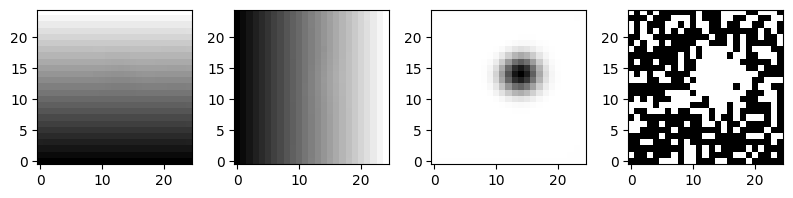

In [ ]:
output = lodestar(next(iter(dataloader))).detach()

plt.figure(figsize=(10, 2))
for i in range(4):
	plt.subplot(1, 5, i + 1)
	plt.imshow(output[1,i,...], cmap="gray", origin="lower")
	# plt.scatter(position[1], position[0], c="r")
plt.tight_layout()
plt.show()

test
torch.Size([8, 6, 25, 25])


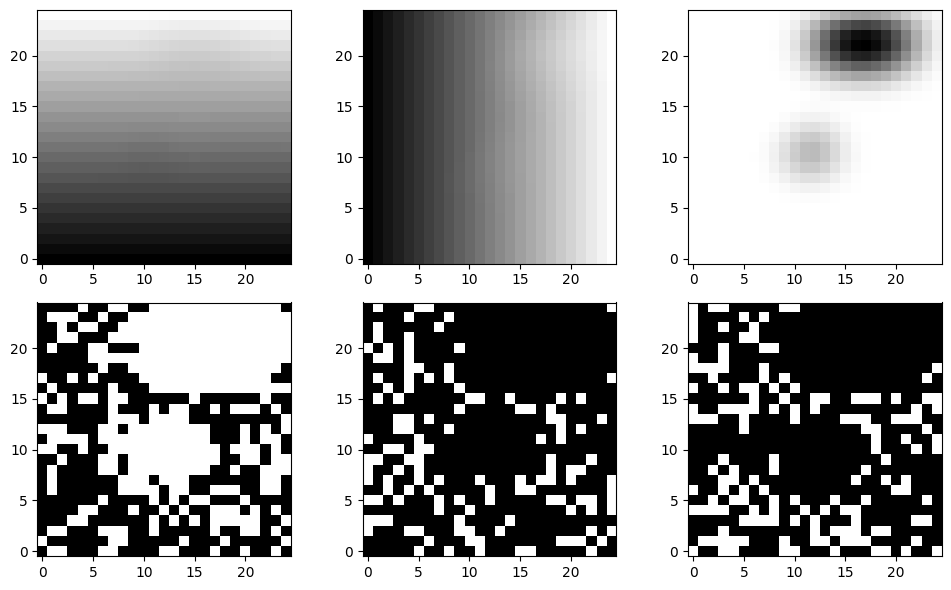

In [ ]:
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=True)
lodestar.eval()
output = lodestar(next(iter(test_dataloader))).detach()
print(output.shape)

plt.figure(figsize=(10, 6))
for i in range(6):
	plt.subplot(2, 3, i + 1)
	plt.imshow(output[1,i,...], cmap="gray", origin="lower")
	# plt.scatter(position[1], position[0], c="r")
plt.tight_layout()
plt.show()
